# Policy Iteration 

In [1]:
# adapt the value_iteration.py code to be policy_iteration

# policy iteration
import numpy as np
from random import randint

# display output
from random import uniform
import time
from IPython.display import display, clear_output

actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) # total number of actions
gridSize = 5 # create a square grid of gridSize by gridSize
state_count = gridSize*gridSize # total number of states

# iterations = 0
theta = 0.000001
discount_factor = 0.8
delta_list = []

## Gridworld Class 

In [2]:
class Gridworld():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        self.new_pos = [0, 0] # initialize new position for p_transition
        self.pos_check = [0, 0] # a copy of new position
        self.transition_prob = 1 # deterministic
    
    def initial_state(self):
        # randomly generate an initial state
        i = random.randint(0, len(self.states)-1)
        rand_state = self.states[i]
        return rand_state
    
    def possible_states(self):
        # return the possible states
        return self.states
    
    def reward(self, current_pos, action):
        # return the reward        
        
        # take action in current pos
        self.new_pos = np.array(current_pos) + np.array(action)

        # normally, reward = 0
        reward = 0

        # if new pos results in off the grid, return reward -1
        if -1 in self.new_pos or self.size in self.new_pos:
            reward = -1
        # if in state A, transition to state A'
        if current_pos == [0, 1]:
            reward = 10
        # if in state B, transition to state B'
        if current_pos == [0, 3]:
            reward = 5
        return reward
    
    # def transition_probability(self, current_pos, new_pos):
        # a function that returns the entries of the transition probability matrix?
        # eg. input current state, new state, output = 0.25...0.5...1 ... etc. ?
    
    def p_transition(self, current_pos, action):
        # return the transition probability
        # get next position: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_pos = np.array(current_pos) + np.array(action)
        self.pos_check = self.new_pos # make a copy of new pos before being overwritten below

        # if taking an action crosses the border = agent stays in same position
        if -1 in self.new_pos or self.size in self.new_pos: 
            self.new_pos = current_pos
            
        # if in state A, transition to state A'
        if current_pos == [0, 1]:
            self.new_pos = [4, 1]
            
        # if in state B, transition to state B'
        if current_pos == [0, 3]:
            self.new_pos = [2, 3]
        return self.new_pos

## Policy Evaluation Function 

In [3]:
def policy_evaluation(value_map, states, discount_factor, theta, reward, transition, trans_prob, policy):
    iterations = 0
    delta_list = []
    while True:
        delta = 0
        iterations+=1
        valueMap_copy = np.copy(value_map)

        # start with the first state in the state list
        for state_number, state in enumerate(states):
            value = 0

            # perform 4 actions per state and add the rewards (value)
            for action_number, action in enumerate(actions):

                # get next position and reward
                new_position = transition(state, action)
                rewards = reward(state, action)

                # calculate value: policy*transition_prob*[r + gamma * value(s')]
                value += policy[state_number][action_number]*trans_prob*(rewards+(discount_factor*value_map[new_position[0], new_position[1]]))          

            # replace the value in valueMap with the value
            valueMap_copy[state[0], state[1]] = value

            # calculate delta
            delta = max(delta, np.abs(value - value_map[state[0], state[1]]))      
            clear_output(wait=True)
            display('delta: ' + str(delta) + ' iterations: ' + str(iterations))

        # save data for plot
        delta_list.append(delta)

        # overwrite the original value map (update valuemap after one complete iteration of every state)
        value_map = valueMap_copy

        # stop when change in value function falls below a given threshold
        if delta < theta:
            break
    
    return value_map, iterations, delta_list, policy

##  Policy Iteration

In [4]:
# UNCOMMENT THE FOLLOWING FOR EVEN POLICY
# # initialize a policy: create an array of dimension (number of states by number of actions)
# # for equal probability amongst all actions, divide everything by the number of actions
# policy = np.ones([state_count, action_count]) / action_count

# Initiate a random policy
random_policy = np.random.randint(1000, size=(state_count, action_count))
random_policy = random_policy/random_policy.sum(axis=1)[:,None]
policy = random_policy

# create a grid object
grid = Gridworld(5)

def calculate_action_value(state, value):
    A = np.zeros(action_count)
    
    # perform 4 actions per state and add the rewards (value)
    for action_number, action in enumerate(actions):
            
        # get next position and reward
        new_position = grid.p_transition(state, action)
        reward = grid.reward(state, action)
        
        # get next position and reward
        new_position = grid.p_transition(state, action)
        reward = grid.reward(state, action)

        # calculate value of action: transition_prob*[r + gamma * value(s')]
        A[action_number] += grid.transition_prob*(reward+(discount_factor*value[new_position[0], new_position[1]]))
    
    return A

In [5]:
final_max_iter = 0

# POLICY ITERATION #####################################3
while True:
    
    # POLICY EVALUATION ####################################
    # run policy evaluation
    final_value_map, max_iter, delta, policy = policy_evaluation(grid.valueMap, grid.states, discount_factor, theta, grid.reward, 
                                                                    grid.p_transition, grid.transition_prob, policy)

    # for plotting purpose
    final_max_iter += max_iter
    delta_list.extend(delta)

    # POLICY IMPROVEMENT #######################################
    # initate policy_true as stable
    policy_stable = True

    # iterate over every state
    for state_number, state in enumerate(grid.states):

        # choose the best action with the current policy
        choose_action = np.argmax(policy[state_number])

        # calculate the action values for each state using the current value function
        # eg. action_values = [#, #, #, #] = a value for each of the 4 actions
        action_values = calculate_action_value(state, final_value_map)

        # using the calculated action values, find the best action
        best_action = np.argmax(action_values)

        # if the chosen action is different than the calculated best action
        # then the current policy is not stable
        if choose_action != best_action:
            policy_stable = False

        # update the current policy with the new best action
        policy[state_number] = np.eye(action_count)[best_action]

    # if the policy is stable (eg. chosen action is the same as best action)
    # then we can exit
    # however, if it is not, then we need to perform policy evaluation and improvement again
    if policy_stable:
        break

'delta: 8.424983333199521e-07 iterations: 74'

## Print Policy Table 

In [6]:
# PRINT POLICY TABLE ################################################################################
# import pandas library
import pandas as pd
# define column and index
columns=range(grid.size)
index = range(grid.size)
# define dataframe to represent policy table
policy_table = pd.DataFrame(index = index, columns=columns)

# iterate through policy to make a table that represents action number
# as action name (eg. left, right, up, down)
for state in range(len(policy)):
    for action in range(policy.shape[1]):
        if policy[state][action] == 1:

            # calculate the row and column coordinate of the current state number
            row = int(state/grid.size)
            column = round((state/grid.size - int(state/grid.size))*grid.size)

            # get action name
            if action == 0:
                action_name = 'up'
            elif action == 1:
                action_name = 'right'
            elif action == 2:
                action_name = 'down'
            else:
                action_name = 'left'
            
            # assign action name
            policy_table.loc[row][column] = action_name

print("Policy Table: ")
print(policy_table)
print()
print("Value Map: ")
print(final_value_map)

Policy Table: 
       0   1     2   3     4
0  right  up  left  up  left
1     up  up    up  up    up
2     up  up    up  up    up
3     up  up    up  up    up
4     up  up    up  up    up

Value Map: 
[[11.89909503 14.87386878 11.89909503 10.24590109  8.19672087]
 [ 9.51927602 11.89909503  9.51927602  8.19672087  6.55737636]
 [ 7.61542082  9.51927602  7.61542082  6.55737636  5.24590109]
 [ 6.09233598  7.61542082  6.09233598  5.24590109  4.19672087]
 [ 4.87386878  6.09233598  4.87386878  4.19672087  3.35737636]]


## Graph Convergence

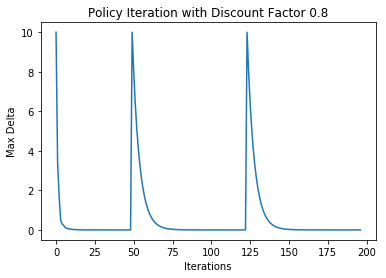

In [10]:
# PRINT DELTA PLOT #####################################################################
import matplotlib.pyplot as plt
# plot iteration vs delta
plt.plot(range(final_max_iter), delta_list)
plt.title('Policy Iteration with Discount Factor ' + str(discount_factor))
plt.xlabel('Iterations')
plt.ylabel('Max Delta')
plt.savefig('graphs/Policy-'+str(discount_factor)+'.png')